<h3>"Call a daggum timeout!"</h3>

-Roy Williams, probably never

Basketball fans generally believe that calling timeouts can slow or stop scoring runs. Certain coaches (famously, Roy Williams) are often criticized for not calling timeouts in an attempt to end a run. However, to the best of my knowledge, this general wisdom has never been tested nor supported by any actual analysis. I intend to use a large dataset (all of the play-by-play data available from ESPN) and some straightforward statistical analysis to show that calling timeouts midgame to end scoring runs has minimal effect on stopping scoring runs.

Scoring runs are expected in any contest just by chance. This can easily be seen from simple coin flips. If a team is expected to convert 50% of their possessions (equivalent to a coin flip), then they can be expected to convert several in a row while the other team converts none. In this way, scoring runs should occur in most basketabll contests. In the same way, these scoring runs should be expected to follow similar probability distributions for when they end. That is, after a scoring run starts, it should have a predictable probability of ending due to the same chances of making baskets. I am going to show that calling a timeout either does not speed up the rate at which a run ends or even negatively increases the length of the run.

I believe that far too much emphasis is placed on "momentum", and players should be expected to recognize these "slumps" and "streaks" as statistically probable events; that is, these scoring streaks and slumps should be expected to regress to the mean over time and end naturally. I believe timeouts have no effect on the ability of a team to recover from such a streak. Furthermore, the team on the run also has the ability to rest and strategize.

Another factor in real basketball games that needs to be considered is the fact that basketball has very frequent time stoppages. In this analysis, stoppages other than timeouts will not be included as causes for "settling" a run, but it stands to reason that timeouts become even less necessary when other time stoppages are considered, as the break in play provides time for quick communication from a coach, substitition of better players for tired/injured/otherwise hindered players or better matchups, and, more importantly, settling "frazzled" players, which is the most common justification for this strategy. In future works, I'd like to explore whether this conjecture about the positive effects of other stoppages in play is true.

Additionally, I believe that experience, i.e., "playing through" a cold streak or weathering runs towards the ends of games, results in increased overall win percentage and, in particular, post-season success. I'd also like to perform a similar analysis on games presumably lost due to running out of timeouts. <a href="https://youtu.be/7HhZBaCAa80?t=702">Here's a nice example.</a>

<b>Disclaimer: This is all an exercise in probability and data scraping. I do believe that there are mental components to athletic contests, and scoring is not independent of these factors. However, I think that a coach could easily coach their team to not expect or wait for timeouts in the case of runs and it would not have a negative effect on their performance.</b>

Now, to perform this analysis, we need to identify the beginnings and ends of runs. Obviously, there is no objective "best" way to decide these properties, so I attempted to write all of the analysis with a great deal of flexibility and across ranges of values. I made best guesses using values that I considered justifiable.  

Using this information and Bayes' Theorem, we'll determine if calling a timeout helps to stop runs.

In [1]:
# First, we need to import modules and load some dictionaries. 
# The data were scrapped from ESPN's play-by-play reports for each game.
# The webscraping code is available on github/comma3. The dictionaries contain 
# relationships between team names, team abbreviations and ESPN's internal
# codes for each team.

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import sqlite3

# Number of events to include (-1)
event_length = 2

def read_dictionary(filename):
    """
    Opens the indicated filename and creates a list line by line using the first entry on each line
    as the key and the second as the value
    """
    dictionaryoutput = {}
    with open(filename) as file:
        entries = csv.reader(file)
        for item in entries:
            dictionaryoutput[item[0]] = item[1]
    return dictionaryoutput

ABRDict = read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\ABRdictionary.csv')
NUMDict = read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\NUMdictionary.csv')


The play-by-play data were scrapped from ESPN's play-by-play reports for each game (e.g., http://www.espn.com/mens-college-basketball/playbyplay?gameId=400872229) and are stored in a database. We are only considering scoring events and timeouts, and we exclude a list of games due to errors in the source data. There are a number of cases that make the data unusable. In some cases, scores were only added to one team, resulting in games with final scores of, for example, 163-0. Game events were occasionally duplicated, out of order, or given the same time stamp for several consecutive events. The discovery of these games is dicussed below. Bad games are removed completely as the entire set is unreliable.

In [2]:
conn = sqlite3.connect('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\data\\CBBdb.sqlite3')
curr = conn.cursor()

# Exclude unused events and corrupted data
data = pd.read_sql_query("""SELECT rowid,*
                        FROM playbyplay
                        WHERE LOWER(event) not like '%free throw%'
                        AND (LOWER(event) like '% made %' OR LOWER(event) like '% timeout%')                       
                        AND game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', 303172239, 290450275,
                        280472483, 283472390, 290450275, 290650087, 293170041, 260280218, 263240150, 270170222,
                        400498526, 400591228, 273332603, 310630171) LIMIT 100000""", conn)

# We imported the entire DB for debugging and obtained final game scores from it out of conenvience 
# (although that is not strictly necessary, and other less memory intensive approaches could be used for this purpose)
all_data = pd.read_sql_query("""SELECT rowid, *
                        FROM playbyplay""", conn)

conn.close()

# Ensure that numbers are numeric values and not strings.
data = data.apply(pd.to_numeric,errors='ignore')
all_data = all_data.apply(pd.to_numeric,errors='ignore')

In [3]:
# Preview the data to esnure that everything was imported correctly
data.head(2)

,rowid,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,2,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3
1,5,253120183,2005-11-09,4,1146,183,Demetris Nichols made Three Point Jumper.,BCU,SYR,0,6


In [4]:
# Check that these values make sense
data.describe()

,rowid,game_id,event_index,time,actor,away_score,home_score
count,100000.00000,1.000000e+05,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000
mean,227347.94546,2.659807e+08,140.0590,579.503790,752.946180,33.299800,37.654520
std,130040.46664,7.643211e+06,84.5477,344.236233,997.431893,20.716425,22.927315
min,2.00000,2.531202e+08,0.0000,0.000000,-1.000000,0.000000,0.000000
25%,114996.25000,2.603523e+08,67.0000,272.000000,103.000000,16.000000,18.000000
50%,228992.50000,2.636202e+08,138.0000,578.000000,222.000000,32.000000,36.000000
75%,339491.25000,2.731002e+08,208.0000,887.000000,2083.000000,49.000000,55.000000
max,450989.00000,2.801926e+08,414.0000,1200.000000,3084.000000,106.000000,128.000000


We need to divide games into periods so that we don't span halftime, overtime or different games. Separating games into periods ensures that clock behavior is consistent and that score differentials are not calculated across periods or games.

In [5]:
# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():   
    time = row['time']     
    if time > lasttime:
        period = data[lastindex:i]
        period['game_id'].values[0]
        periods.append(data[lastindex:i])
        lastindex = i
    lasttime = time
    
#Add the last period
periods.append(data[lastindex:i])

<h3>How do we find runs?</h3>

First, we record the change in the score margin ($\Delta scoremargin$) between the two teams. We are interested in scoring runs, which we will identify as increases in the absolute value of $\Delta scoremargin$ (that is, one team is scoring more points than the other and increasing/decreasing the score margin).

First, we exclude the ends of periods because timeout usage and general clock management change dramatically towards the ends of games. As mentioned previously, I would like to explore this time period in the future, as one of the proposed strategic elements of timeouts is preserving them for the ends of games.

Then, we record the score difference between the two teams (not the change in score difference, i.e., $\Delta scoremargin$, but simply the margin in the score $scoremargin$). A positive value indicates that the home team is winning.

Now, we find $\Delta scoremargin$ by calculating the difference between the score margins at two different times. As discussed above, each event is either a made basket or a timeout. In this work, we calculate the difference in margin across three events because we are using $\Delta scoremargin >= 6$ across three events (timeouts and made baskets) as our criteria for a run. Including timeouts reduces the number of events identified as runs, as in principle, the timeout should reduce the likelihood of a run starting. That is, sequences like $home score$, $timeout$, $home score$, $home score$ won't be identified as runs, even when they probably should be (and in particular a run not stopped by a timeout, which is the figure I believe to be much higher than fans generally believe).

Based on manual inspection, the sequences identified by this algorithm tend to "feel" like runs (i.e., situations where fans start screaming for TOs). 

To give example numbers for this analysis, if a game begins with a score of 0-0, the $score margin$ is zero. Three "events" later, the score is 3-4 (one 3pt and two 2pts) and the $score margin$ is -1 $(3 - 4 = -1)$. Thus, the change in the score difference ($\Delta scoremargin$) is -1 $(-1 - 0 = -1)$. Then, three more events later, the score is 3-10. The score difference is -7 $(3 - 10 = -7)$ and $\Delta scoremargin$ is -6 $(-7 - (-1) = -6)$. That is, the difference in score has increased by -6 (negative indicates away team). This value, $|\Delta scoremargin|$ >= 6, represents the minimum criteria for a run to start. The analysis gives the same absolute value if the scores were reversed (i.e., the home team went on the run).

Note that free throws are not included as events in this analysis, but the points are included. That is, free throws can prevent the start of a scoring run even if a team makes no field goals. For example, if a team scores 3 consecutive baskets, but fouls on every possesion at the other end, $|\Delta scoremargin|$ could be less than 6, and we do not consider this sequence of events to represent a scoring run. Alternatively, a team may not need three consecutive baskets to start a scoring run. For example, two 3pts and an opposing 2pt could start a run if the opposing team also fouled in that time frame.

In [6]:
score_margin_dict = {}
for i,period in enumerate(periods):
    # Drop ends of periods because strategy can change
    period = period.loc[period['time'] > 90]
    
    # Current score margin
    # Will be used with diff below to calculate change in score difference
    period['delta_score_margin'] = period['home_score'] - period['away_score']
        
    average_score_margin = period['delta_score_margin'].mean()
    #score_margin_list.append(average_score_margin)
    score_margin_dict[period['game_id'].values[0]] = average_score_margin



c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# Calculating the quantities described above.

# List that holds the differences from each period
differences = []

# The following list and dictionary are used to calculate the average score margin.
# Based on the above analysis, we only want to analyze games that were
# competitive because scoring streaks are very common in games where
# teams are not comptetitive. The effectiveness of timeouts in games where
# teams are not evenly matched is not being tested.

# We use a dictionary so we can identify game-by-game avarage score margins.
# key : game_id, value : average score margin
score_margin_dict = {}

# The list is only used to investigate the data
score_margin_list = []

# We could eliminate games based on average score margins here to speed up the analysis
# but I'm leaving all of the data in the analysis as long as possible in case the
# approach needs to change or the specific cutoff criteria change.
for period in periods:
    # Drop ends of periods because strategy can change
    period = period.loc[period['time'] > 90]
    
    # Current score margin
    # Will be used with diff below to calculate change in score difference
    period['delta_score_margin'] = period['home_score'] - period['away_score']
        
    try:
        average_score_margin = period['delta_score_margin'].mean()
        score_margin_list.append(average_score_margin)
        score_margin_dict[period['game_id'].values[0]] = average_score_margin
    except:
        print(period)
        print(periods.index(period))
        continue
    
    # Get delta time and delta score difference
    difference = period[['time','delta_score_margin']].diff(event_length)
    
    # Pass data forward - need to copy from the undiffed data frame
    difference['row_id'] = period['rowid']
    difference['game_id'] = period['game_id']
    difference['event'] = period['event']
    difference['actor'] = period['actor']
    difference['home'] = period['home']
    difference['away'] = period['away']
    difference['home_score'] = period['home_score']
    difference['away_score'] = period['away_score']
    difference['score_margin'] = period['home_score'] - period['away_score']
    
    # Passage of time (delta_time) should be positive but difference is calculated from a counting down clock.
    difference['delta_time'] = -difference['time']
    difference['time'] = period['time']
    
    # Because we are using diff, the first few rows of a period cannot be calculated and give not a number
    # so we drop them as meaningless
    difference = difference[['game_id','row_id','event','actor','home','away','home_score', 'away_score','score_margin','time','delta_time','delta_score_margin']].dropna()
    differences.append(difference)

# We can combine all of these values into one dataframe again because we no longer have to worry about overlapping adjacent events 
result = pd.concat(differences)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now, we examine our data to make sure it all makes sense. I've already excluded many games (see list above in the SQL query) because they were identified using these techniques to have corrupted data.

In [8]:
# Checking for infinite values
result.loc[(result.delta_score_margin == np.inf) | (result.delta_score_margin == np.inf)]

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin


In [9]:
# We start with the average score margin, which we will use to eliminate uncompetitive games
score_margin_df = pd.DataFrame({'scores':score_margin_list})
score_margin_df.describe()

,scores
count,3217.000000
mean,3.980297
std,10.472041
min,-32.861111
25%,-2.210526
50%,2.833333
75%,9.068966
max,57.575758


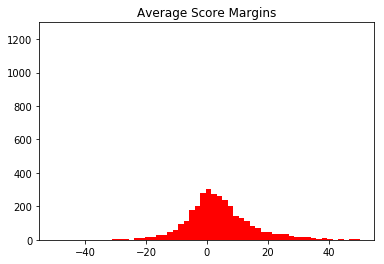

In [10]:
# Everything looks pretty expected here. 
# As will be common, there is a slight skew toward the home team.
fig = plt.figure()
plt.ylim([0,1300])
plt.xlim([-55,55])
plt.hist(score_margin_df.scores, bins=50, color='r', alpha=1, label='diff')
plt.title("Average Score Margins")
plt.show()

In [11]:
# On to the analysis data
result.describe()

,game_id,row_id,actor,home_score,away_score,score_margin,time,delta_time,delta_score_margin
count,8.474200e+04,84742.000000,84742.000000,84742.000000,84742.000000,84742.000000,84742.000000,84742.000000,84742.000000
mean,2.659691e+08,227254.913608,754.573022,36.989380,32.521902,4.467478,595.612671,73.042458,0.244283
std,7.651006e+06,130159.383004,998.512598,22.035542,19.645238,11.738012,293.853920,40.789061,2.674368
min,2.531202e+08,6.000000,-1.000000,0.000000,0.000000,-46.000000,91.000000,-0.000000,-12.000000
25%,2.603522e+08,114724.750000,103.000000,18.000000,15.000000,-3.000000,341.000000,43.000000,-2.000000
50%,2.636200e+08,228452.000000,222.000000,36.000000,31.000000,3.000000,597.000000,64.000000,0.000000
75%,2.731200e+08,340031.250000,2084.000000,54.000000,48.000000,11.000000,855.000000,94.000000,2.000000
max,2.801926e+08,450978.000000,3084.000000,125.000000,106.000000,70.000000,1175.000000,474.000000,12.000000


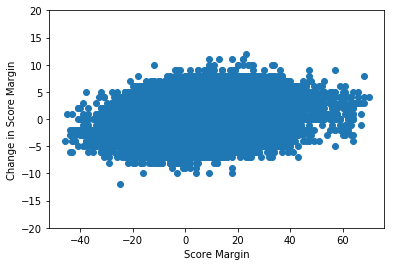

In [12]:
plt.scatter(result['score_margin'],result['delta_score_margin'])
plt.ylim([-20,20])
plt.xlabel('Score Margin')
plt.ylabel('Change in Score Margin')
plt.show()

In [13]:
# We manually investigate the games 
result.loc[(result['delta_score_margin'] > 10)]

# We can use the code in the next cell to look at specific games 
# all_data.loc[(all_data.game_id == 253130183)]
# or the link
# http://www.espn.com/mens-college-basketball/playbyplay?gameId=400872229
# substituting in the game_id

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
12156,253640251,56354,Brad Buckman made Two Point Layup.,251,TEX,PV,32,10,22,303,174.0,11.0
22960,260300222,106233,Mike Nardi made Three Point Jumper. Assisted ...,222,NOVA,LOU,61,48,13,757,180.0,11.0
46631,263400057,213831,Lee Humphrey made Two Point Layup.,57,FLA,PROV,76,54,22,261,87.0,11.0
48555,263530153,222633,Reyshawn Terry made Three Point Jumper.,153,UNC,FAU,23,5,18,820,125.0,11.0
48556,263530153,222643,Tyler Hansbrough made Two Point Dunk Shot. As...,153,UNC,FAU,28,5,23,733,161.0,12.0
54569,270130269,249596,David Cubillan made Three Point Jumper. Assis...,269,MARQ,WVU,19,10,9,707,184.0,11.0


In [14]:
#all_data.loc[(all_data.game_id == 253130183)]

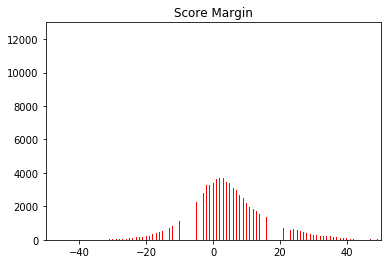

In [15]:
fig = plt.figure()
plt.ylim([0,13000])
plt.xlim([-50,50])
plt.hist(result['score_margin'], bins=500, color='r', alpha=1, label='diff')
plt.title("Score Margin")
plt.show()

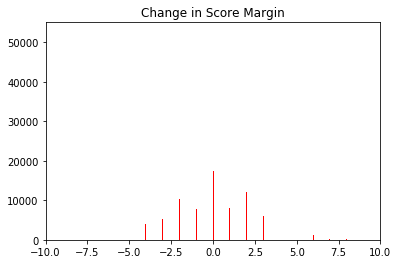

In [16]:
fig = plt.figure()
plt.ylim([0,55000])
plt.xlim([-10,10])
plt.hist(result['delta_score_margin'], bins=500, color='r', alpha=1, label='diff')
plt.title("Change in Score Margin")
plt.show()
# 1pt score differentials are slightly depressed as expected

In [17]:
# The pd.diff calculation above can be somewhat slow, so we can save/load the results here to speed up analysis.

#result.to_csv('run_calculation_diff2.csv', encoding='utf-8')
#result = pd.read_csv('run_calculation_diff3.csv', header = 0)

In [18]:
result.head()

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
2,253120183,6,Sam Barber made Two Point Jumper.,2065,SYR,BCU,6,2,4,1125,51.0,1.0
3,253120183,7,Antonio Webb made Three Point Jumper.,2065,SYR,BCU,6,5,1,1105,41.0,-5.0
4,253120183,12,Demetris Nichols made Three Point Jumper.,183,SYR,BCU,9,5,4,1026,99.0,0.0
5,253120183,17,Terrence Roberts made Two Point Layup.,183,SYR,BCU,11,5,6,988,117.0,5.0
6,253120183,18,Michael Williams II made Two Point Jumper.,2065,SYR,BCU,11,7,4,968,58.0,0.0


In [19]:
# Now, we collect the situations that qualify as runs based on our previous discussion.
runs = result.loc[(result.delta_score_margin > 6) | (result.delta_score_margin < -6)]

In [20]:
runs.head()

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
16,253120183,90,Gerry McNamara made Three Point Jumper.,183,SYR,BCU,25,10,15,307,199.0,7.0
478,253182294,2252,Alex Thompson made Two Point Dunk Shot. Assis...,2294,IOWA,UMES,80,33,47,329,75.0,8.0
522,253190235,2540,Rodney Carney made Two Point Dunk Shot. Assis...,235,MEM,MILW,60,38,22,536,91.0,8.0
523,253190235,2552,Rodney Carney made Three Point Jumper. Assist...,235,MEM,MILW,63,39,24,487,122.0,8.0
540,253192294,2655,Erek Hansen made Two Point Jumper. Assisted b...,2294,IOWA,COLG,11,3,8,951,139.0,7.0


In [21]:
runs.describe()

,game_id,row_id,actor,home_score,away_score,score_margin,time,delta_time,delta_score_margin
count,6.720000e+02,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,2.660405e+08,229968.327381,623.891369,40.831845,33.851190,6.980655,558.119048,118.483631,2.066964
std,7.957917e+06,135061.916513,903.898852,22.917073,19.953938,14.645984,277.504980,46.671440,7.166945
min,2.531202e+08,90.000000,-1.000000,0.000000,0.000000,-31.000000,93.000000,12.000000,-12.000000
25%,2.602818e+08,103075.500000,103.000000,22.000000,17.000000,-3.000000,317.750000,86.750000,-7.000000
50%,2.700202e+08,234253.500000,221.000000,39.000000,32.000000,6.500000,526.500000,110.000000,7.000000
75%,2.732100e+08,351076.500000,277.000000,59.000000,49.000000,16.000000,780.250000,142.000000,7.000000
max,2.801902e+08,450827.000000,2752.000000,104.000000,89.000000,68.000000,1117.000000,372.000000,12.000000


<h3>How do we identify the end of a run?</h3> 

Does a single basket end a run? That seems a bit generous to me.

Does the team that's "slipping" need to make a complete comeback? That seems like a really difficult requirement to satisfy.

I think the natural minimum requirement is returning to trading baskets (i.e., $\Delta scoremargin = 0$). Even if the running team still holds a lead (or made a comeback), the damage is at least somewhat mitigated. However, an informal survey I conducted had suggestions of even lower requirements than trading baskets. Therefore, I am going to explore a range of scoring ratios as the ending criterion. Using a ratio also includes the minimum requirement that the slipping team scores at least 1 point as, otherwise, we will produce a divide by zero error (which we just handle as not stopping the run).

A value of the ratio $\frac{runner score}{slipper score} <= 1$ indicates that the slipping team has scored at least as many points as the running team (i.e., trading baskets or better) and is the minium tested value for ending a run. In contrast, the ratio $\frac{runner score}{slipper score} >= 2$ indicates that the running team is scoring points at a 2:1 ratio, which I would contest indicates that the running team is still very much on a run. I maintain that the 1:1 scoring ratio seems best as a criterion for "ending a run", but we will calculate other values for argument's sake.

In the analysis below, we collect the ten scoring and timeout events after a run is considered to have started. We are only interested in the first few possession after a run and subsequent timeout. If a run doesn't end within ten events after the start of the run, it is effectively considered to have not been stopped; I believe this to be a very generous time horizon for a slipping team to end a run. We aren't interested in extending the time to infinity as strategies can change with large leads and near the ends of games and nearly all runs will "end" when sufficiently large margins are acheived.

As presented above, runs are considered to end when the score ratio $\frac{runner score}{slipper score} <=$ the indicated ratio (from 1 to 2) or two timeouts are called (as the first timeout is thus deemed inadequate to stop a run). We can also differentiate these scenarios based on the type of timeout (runner called, slipper called, or official/TV).

From this information, we are going to caluclate certain probabilities:

1) The overall probability that a run ended (and its inverse that a run did not end).

2) The probability that a timeout was called and the run ended.

3) The probability that a timeout was called and the run did not end.

From these probabilities and Bayes' Theorem, we can calculate the probability that the timeout was responsible for the run ending. In other words, would a stopped run have stopped without the timeout? Frequentist statistics can also be directly observed.

In [22]:
diff_length = event_length # This value comes from the diff function above.

different_stop_criteria = []
# Choosing the correct criteria for a run stop is difficult, so I'll go ahead and
# calculate a range so you can argue about it.
run_criteria = [1 + x/10 for x in range(11)]

for run_criterion in run_criteria:
    run_stops = []
    indx = 0
    for i,row in runs.iterrows():
        # If rows are consecutive, they belong to the same run, so we group them and skip ahead
        if result.loc[result.row_id == row['row_id']].index[0] == indx + 1:
            indx = result.loc[result.row_id == row['row_id']].index[0]
            continue

        # We use the index from the original dataset to find the events
        indx = result.loc[result.row_id == row['row_id']].index[0]

        # Grab a few extra events - if run doesn't end after 10 events or 2 timeouts, it's considered to not end
        working = result.loc[(result.index >= indx - diff_length) & (result.index <= indx + 10)]
        # Reset the index for the slice
        working = working.reset_index()
        del working['index']

        # Collect some values
        run_start_time = row['time']

        team_list = [data.loc[(data.rowid == row['row_id'])]['home'].values[0], data.loc[(data.rowid == row['row_id'])]['away'].values[0]]
        runner_index = 0 if row['delta_score_margin'] > 0 else 1
        runner = team_list[runner_index]

        run_ended = False

        timeouts = []
        score_log = []
        last_time = 1200
        for j,event in working.iterrows():
            # Need to guarntee that we collect these values
            if j == diff_length:
                    run_start_scores = [event['home_score'], event['away_score']]

            # If the slice range crosses a period skip the rows from the old period.
            if run_start_time > event['time'] and j < diff_length:  # Shouldn't happen
                continue

            # Or if the slice crosses ahead into a new period or game, we end the run
            # New period
            if last_time - event['time'] < 0:
                timeouts.append([j, 'End Game', '', ''])
                break
            last_time = event['time']
            # New game - should get caught by new conditional above but just in case
            if event['home'] not in team_list:
                timeouts.append([j, 'End Game', '', ''])
                break

            if 'timeout' in event['event'].lower():
                # If we get a second stop in play after the run starts, we are going to consider the run not stopped
                attempt_stop = 0
                if j > diff_length:
                    attempt_stop += 1
                if timeouts:
                    for timeout in timeouts:
                        if timeout[0] > diff_length:  # We don't want to stop the run for TOs during the build up
                            attempt_stop += 1
                # We don't break here as we might want to know about this timeout. We'll break after adding the TO info.

                # Check if timeout caller is winning
                try:
                    caller = NUMDict[str(event['actor'])]
                except:
                    caller = 'error'
                # ESPN doesn't use a separate icon for official TOs, instead just using one of the teams
                # We manually override this flaw.
                if ' tv ' in event['event'].lower():
                    caller = 'tv'
                # Identify currently winning team
                is_winning = caller == ABRDict[team_list[0] if event['home_score'] - event['away_score']  >= 0 else team_list[1]]
                # Check if the TO caller is the team that is running (unlikely)
                is_running = caller == ABRDict[runner] # tv == False
                timeouts.append([j, caller, is_winning, is_running, [event['home_score'], event['away_score']]])
                if attempt_stop >= 2:  # But if we have two TOs during a run, we are going to consider it not stopped
                    break
                # No scoring occurred so we don't need to finish the loop (prevent duplicates from being added to score_log)
                continue 
            else:
                score_log.append([j,[event['home_score'],event['away_score']]])

            if j > diff_length + 4 and len(score_log) > 2:
                # Slipping team made somewhat of a comeback 
                # (0 - 1 = -1 == 1 in two item list)
                slipper_score_margin = score_log[-1][1][runner_index-1] - run_start_scores[runner_index-1]
                runner_score_margin = score_log[-1][1][runner_index] - run_start_scores[runner_index]
                try:
                    if runner_score_margin / slipper_score_margin <= run_criterion:
                        run_ended = True
                        break
                except:
                    # If the slipper hasn't scored, we don't care and move on
                    pass

        # Get Final score
        final = all_data.loc[(all_data.game_id == row.game_id)].tail(1)
        final_scores = [final['home_score'].values[0], final['away_score'].values[0]]
        # Use final score to determine the index of the winning team
        winner = team_list[0 if (final['home_score'].values > final['away_score'].values) else 1]
        run_stops.append([event.game_id, team_list, winner, runner, run_ended, timeouts, score_log, final_scores])
        
    different_stop_criteria.append([run_criterion, run_stops])



Okay. Now we have the probabilities that we need to use Bayes' Theorem to determine the probability that a timeout has an effect on a scoring run. A very good explanation that can help with intuitive understanding can be found at <a href = 'https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/'>betterexplained.com</a>. The theorem will be described briefly here:

$$P(Run Ended | Timeout Called) = \frac{P(Timeout Called | Run Ended)P(Run Ended)}{P(Timeout Called | Run Ended)P(Run Ended) + P(Timeout Called | Run Not Ended)P(Run Not Ended)}$$

where P(Run Ended | Timeout Called) = probability that calling a timeout is responsible for ending a run,

P(Timeout Called | Run Ended) = probability that a timeout was called and the run ended, 

P(Run Ended) = probability that a run ends at all (based on our criteria),

P(Timeout Called | Run Not Ended) = probability that a timeout was called but the run did not end,

and P(Run Not Ended) = probability that the run did not end.

In [23]:
score_ratio_list = []
bayes_probs = []
runs_stopped_probs = []
runs_stopped_to_probs = []

for stop in different_stop_criteria:
    score_ratio = stop[0]
    run_stops = stop[1]
    
    total_rows = len(run_stops)
    
    # We want to differentiate who called the timeout
    # I thought about using lists or named tuples, but just variables seemed like
    # it would make the code more readable
    run_stopped = 0
    run_not_stopped = 0
    timeout_and_run_stopped = 0
    timeout_and_run_not_stopped = 0
    tv_timeout_and_run_stopped = 0
    tv_timeout_and_run_not_stopped = 0
    runner_timeout_and_run_stopped = 0
    runner_timeout_and_run_not_stopped = 0
    slipper_timeout_and_run_stopped = 0
    slipper_timeout_and_run_not_stopped = 0


    for row in run_stops:
        end_game = False
        
        # Exclude games that aren't competitive
        # This is an average so it shouldn't be too heavily weighted
        # by scoring at the end of the game because we aren't including
        # free throws as events
        if abs(score_margin_dict[row[0]]) > 5:        
            total_rows -= 1
            continue
        
        # Indicies for row
        # [game_id, team_list, winner, runner, run_ended, timeouts, score_log, final_scores]
        
        # Exclude runs that traverse into end game terroritory
        if row[5]:
            for to in row[5]:
                if to[1] == 'End Game':
                    total_rows -= 1
                    end_game = True
        if end_game:
            continue

        # Run stopped
        if row[4]:
            run_stopped += 1
            # TOs called
            if row[5]: 
                to_counted = False
                for to in row[5]:
                    # TO after the run started
                    if to[0] > diff_length:
                        if not to_counted:
                            timeout_and_run_stopped += 1
                            to_counted = True
                            if to[1] == 'tv':
                                tv_timeout_and_run_stopped += 1
                            elif not to[3]:
                                slipper_timeout_and_run_stopped += 1
                            elif to[3]:
                                runner_timeout_and_run_stopped += 1


        # Run not stopped
        else:
            run_not_stopped += 1
            # TOs called
            if row[5]:
                to_counted = False
                for to in row[5]:
                    if to[0] > diff_length:
                        if not to_counted:
                            timeout_and_run_not_stopped += 1
                            to_counted = True
                            if to[1] == 'tv':
                                tv_timeout_and_run_not_stopped += 1
                            elif not to[3]:
                                slipper_timeout_and_run_not_stopped += 1
                            elif to[3]:
                                runner_timeout_and_run_not_stopped += 1

    # Calculate probabilities
    # Overall probability of a run stopping
    PRS = run_stopped/total_rows
    # Overall probability of run not stopping
    PRNS = run_not_stopped/total_rows
    # Probabiliyt of run stopping when a timeout is called
    PT_RS = timeout_and_run_stopped/(timeout_and_run_stopped + timeout_and_run_not_stopped)
    # Probabiliyt of run not stopping when a timeout is called
    PT_RNS = timeout_and_run_not_stopped/(timeout_and_run_stopped + timeout_and_run_not_stopped)
    
    PTRS_RS = PT_RS * PRS
    PTRNS_TRNS = PT_RNS * PRNS
    
    bayes_prob = (PTRS_RS)/(PTRS_RS + PTRNS_TRNS)
                                
                                
    print('\n+++++++++++++++')                           
    print('Score ratio')
    print(score_ratio)
    print('+++++++++++++++') 
    print('---------------')
    print('Run stopped')
    print('---------------')
    print(run_stopped)
    print('{:.1%}'.format(PRS))
    print('---------------')
    print('Run not stopped')
    print('---------------')
    print(run_not_stopped)
    print('{:.1%}'.format(PRNS))
    print('---------------')
    print('Timeout and run stopped')
    print('---------------')
    print(timeout_and_run_stopped)
    print('{:.1%}'.format(PT_RS))
    print('---------------')
    print('Timeout and run not stopped')
    print('---------------')
    print(timeout_and_run_not_stopped)
    print('{:.1%}'.format(PT_RNS))
    print('---------------')
    print('P(Run Ended|TimeoutCalled)')
    print('---------------')
    print('{:.1%}'.format(bayes_prob))
    
    
    score_ratio_list.append(score_ratio)
    bayes_probs.append(bayes_prob)
    runs_stopped_probs.append(PRS)
    runs_stopped_to_probs.append(PT_RS) 
        


+++++++++++++++
Score ratio
1.0
+++++++++++++++
---------------
Run stopped
---------------
51
38.9%
---------------
Run not stopped
---------------
80
61.1%
---------------
Timeout and run stopped
---------------
45
36.0%
---------------
Timeout and run not stopped
---------------
80
64.0%
---------------
P(Run Ended|TimeoutCalled)
---------------
26.4%

+++++++++++++++
Score ratio
1.1
+++++++++++++++
---------------
Run stopped
---------------
51
38.9%
---------------
Run not stopped
---------------
80
61.1%
---------------
Timeout and run stopped
---------------
45
36.0%
---------------
Timeout and run not stopped
---------------
80
64.0%
---------------
P(Run Ended|TimeoutCalled)
---------------
26.4%

+++++++++++++++
Score ratio
1.2
+++++++++++++++
---------------
Run stopped
---------------
59
45.0%
---------------
Run not stopped
---------------
72
55.0%
---------------
Timeout and run stopped
---------------
52
41.9%
---------------
Timeout and run not stopped
---------------


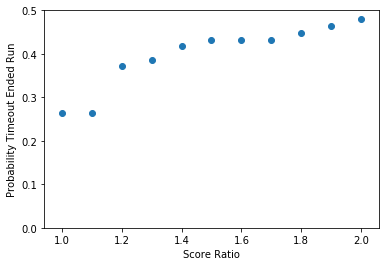

In [24]:
plt.scatter(score_ratio_list, bayes_probs)
plt.ylim([0,0.5])
plt.xlabel('Score Ratio')
plt.ylabel('Probability Timeout Ended Run')
plt.show()

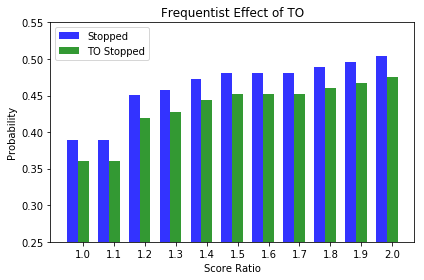

In [25]:
n_groups = 11
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, runs_stopped_probs, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Stopped')
 
rects2 = plt.bar(index + bar_width, runs_stopped_to_probs, bar_width,
                 alpha=opacity,
                 color='g',
                 label='TO Stopped')
 
plt.xlabel('Score Ratio')
plt.ylabel('Probability')
plt.title('Frequentist Effect of TO')
plt.xticks(index + bar_width, ('1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.0'))
plt.legend()

plt.ylim([0.25,0.55])
plt.tight_layout()
plt.show()

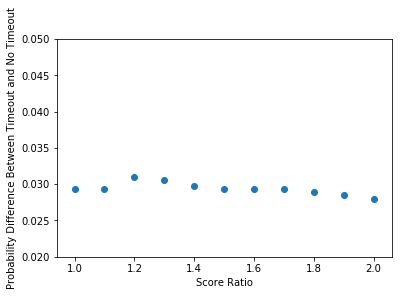

In [26]:
# Just want to show that this isn't constant or monotonic, which would indicate some bias in the method.

probdiff = [x[0] - x[1] for x in zip(runs_stopped_probs, runs_stopped_to_probs)]

plt.scatter(score_ratio_list, probdiff)
plt.ylim([0.02,0.05])
plt.xlabel('Score Ratio')
plt.ylabel('Probability Difference Between Timeout and No Timeout')
plt.show()

<b>"There are three kinds of lies: lies, damned lies, and statistics."</b>

Our naive analysis shows that there's as low as a 22% chance that timeouts are resonsible for ending runs, with even the extremely generous 2:1 scoring ratio yeilding ony 35%. This likely has something to do with the extremely low probability that runs stop at all that seems to be exacerbated by the frequentist probabilities, which show that calling a timeout has an even lower probability of having a run end. 

We haven't even started to consider whether timeouts could even help the running team increase their the length and/or intensity of their run. We have included all types of timeouts, and I would contests we should only be looking at situations where the slipping team calls the timeout.

In short, there is so much room for variation here, that we could make this far worse for timeout proponents or try to hide the results of this naive analysis further.